In [2]:
from datasets import Dataset
import pandas as pd
import spacy
import stanza
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Loading Stanza models for Arabic
stanza.download('ar')

2024-05-05 16:54:29 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-05 16:54:29 INFO: Downloading default packages for language: ar (Arabic) ...
2024-05-05 16:54:30 INFO: File exists: /Users/perrine/stanza_resources/ar/default.zip
2024-05-05 16:54:32 INFO: Finished downloading models and saved to /Users/perrine/stanza_resources


In [3]:
data = pd.read_csv("../../data/csv/data.csv")

# Create a dataset from the pandas dataframe
dataset = Dataset.from_pandas(data)
dataset

Dataset({
    features: ['Label', 'Text'],
    num_rows: 3545
})

In [4]:
# Tokenizers
# Loading SpaCy models
nlp_en = spacy.load("en_core_web_sm")  # English
nlp_es = spacy.load("es_core_news_sm")  # Spanish
nlp_de = spacy.load("de_core_news_sm")  # German
nlp_fr = spacy.load("fr_core_news_sm")  # French
nlp_ru = spacy.load("ru_core_news_sm")  # Russian
nlp_zh = spacy.load("zh_core_web_sm")  # Chinese
nlp_ja = spacy.load("ja_core_news_sm")  # Japanese
nlp_ko = spacy.load("ko_core_news_sm")  # Korean

# Loading StanfordNLP models
nlp_ar = stanza.Pipeline(lang='ar')

def tokenize_and_annotate(text: str, lang: str) -> list:
    """
    Tokenize et annote morpho-syntaxiquement un texte dans une langue donnée.

    Parameters:
    text (str): le texte à tokeniser et annoter.
    lang (str): la langue du texte.

    Returns:
    list: une liste de tuples (token, POS) pour chaque token du texte.
    """
    if lang == 'ar':
        doc = nlp_ar(text)
        return [(word.text, word.upos) for sent in doc.sentences for word in sent.words]
    else:
        nlp = globals()[f"nlp_{lang}"]
        doc = nlp(text)
        return [(token.text, token.pos_) for token in doc]
    

2024-05-05 16:54:38 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-05 16:54:38 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-05 16:54:39 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-05-05 16:54:39 INFO: Using device: cpu
2024-05-05 16:54:39 INFO: Loading: tokenize
2024-05-05 16:54:39 INFO: Loading: mwt
2024-05-05 16:54:39 INFO: Loading: pos
2024-05-05 16:54:40 INFO: Loading: lemma
2024-05-05 16:54:40 INFO: Loading: depparse
2024-05-05 16:54:40 INFO: Loading: ner
2024-05-05 16:54:40 INFO: Done loading processors!


In [5]:
# Number of each entity type per language
def count_entities(dataset: list) -> dict:
    """
    Compte le nombre d'entités de chaque type par langue dans un dataset.

    Parameters:
    dataset (list): le dataset à analyser.

    Returns:
    dict: un dictionnaire dont les clés sont les types d'entités et les valeurs sont des dictionnaires
          dont les clés sont les langues et les valeurs sont les nombres d'entités de ce type dans cette langue.
    """
    entities = {}
    for sentence in dataset:
        text = sentence['Text']
        lang = sentence['Label']
        sentence['tokens_pos'] = tokenize_and_annotate(text, lang)
        for token, pos in sentence['tokens_pos']:
            if pos not in entities:
                entities[pos] = {}
            if lang not in entities[pos]:
                entities[pos][lang] = 0
            entities[pos][lang] += 1
    
    sorted_entities = {pos: dict(sorted(lang_counts.items(), key=lambda item: item[1], reverse=True))
                       for pos, lang_counts in sorted(entities.items(), key=lambda x: x[0])}

    return sorted_entities

def save_entites_csv(entities: dict):
    """
    Sauvegarde les entités dans un fichier CSV.

    Parameters:
    entities (dict): un dictionnaire contenant les entités.
    """
    df = pd.DataFrame(entities)
    df.to_csv("../../resultats/entities.csv")

1. `count_entities(dataset: list) -> dict`

    Cette fonction prend une liste d'objets, chacun représentant une phrase, et compte combien d'entités de chaque type sont présentes dans chaque langue.

    * ***Initialisation**:
        - `entities` : un dictionnaire vide qui stockera le nombre d'entités pour chaque type et chaque langue.

    * **Boucle sur chaque phrase**:
        - La fonction parcourt chaque phrase du `dataset`.
        - `text` et `lang` sont extraits de chaque phrase, respectivement le texte de la phrase et le code de la langue.

    * **Annotation des tokens**:
        - `sentence['tokens_pos'] = tokenize_and_annotate(text, lang)`: une fonction externe est utilisée pour diviser le texte en tokens et les annoter avec leurs types d'entités.
        - La fonction `tokenize_and_annotate()` renvoie une liste de tuples `(token, pos)`, où `token` est un mot et `pos` est le type d'entité associé.

    * **Mise à jour du comptage**:
        - La fonction parcourt les tokens annotés et met à jour le dictionnaire `entities` pour tenir compte de chaque type d'entité (`pos`) trouvé dans la langue (`lang`).
        - Si `pos` ou `lang` n'existent pas encore dans `entities`, ils sont initialisés.

    * **Tri des résultats**:
        - La fonction trie d'abord les types d'entités (`pos`) par ordre alphabétique, puis trie les langues pour chaque type d'entité par le nombre d'occurrences dans un ordre décroissant.

    * **Retourne les résultats**:
        - La fonction retourne le dictionnaire `sorted_entities`, qui contient le comptage des entités par type et par langue.

2. `save_entites_csv(entities: dict)`

    Cette fonction prend un dictionnaire d'entités et les sauvegarde dans un fichier CSV.

    * **Conversion en DataFrame**:
        - `df` : le dictionnaire `entities` est converti en DataFrame pandas. Cela facilite la sauvegarde sous forme de fichier CSV.

    * **Sauvegarde en CSV**:
        - `df.to_csv("../../resultats/entities.csv")`: la DataFrame est sauvegardée dans un fichier CSV à l'emplacement spécifié.


In [6]:
entities = count_entities(dataset)
entities_csv = save_entites_csv(entities)

entities

{'ADJ': {'ru': 2494,
  'en': 2394,
  'es': 1326,
  'fr': 1302,
  'de': 900,
  'ar': 742,
  'zh': 356,
  'ja': 256,
  'ko': 203},
 'ADP': {'en': 4118,
  'ja': 3780,
  'es': 3598,
  'fr': 3511,
  'ru': 2410,
  'de': 1918,
  'ar': 1254,
  'zh': 416,
  'ko': 120},
 'ADV': {'de': 981,
  'en': 966,
  'ko': 830,
  'ru': 793,
  'zh': 764,
  'fr': 698,
  'es': 642,
  'ja': 136,
  'ar': 21},
 'AUX': {'ja': 1627,
  'en': 1272,
  'de': 659,
  'fr': 601,
  'es': 522,
  'ru': 249,
  'ko': 125,
  'ar': 53},
 'CCONJ': {'en': 1004,
  'ru': 760,
  'es': 629,
  'ar': 572,
  'fr': 553,
  'de': 495,
  'ko': 429,
  'zh': 174,
  'ja': 82},
 'DET': {'en': 3024,
  'fr': 2667,
  'es': 2584,
  'de': 2187,
  'ru': 441,
  'ar': 129,
  'zh': 128,
  'ja': 73,
  'ko': 58},
 'INTJ': {'en': 4, 'zh': 3, 'ru': 2},
 'NOUN': {'ja': 6690,
  'ru': 6078,
  'en': 5705,
  'fr': 4242,
  'zh': 3790,
  'es': 3499,
  'de': 3339,
  'ko': 2833,
  'ar': 2251},
 'NUM': {'zh': 506,
  'en': 280,
  'ru': 169,
  'es': 118,
  'fr': 111,
  '

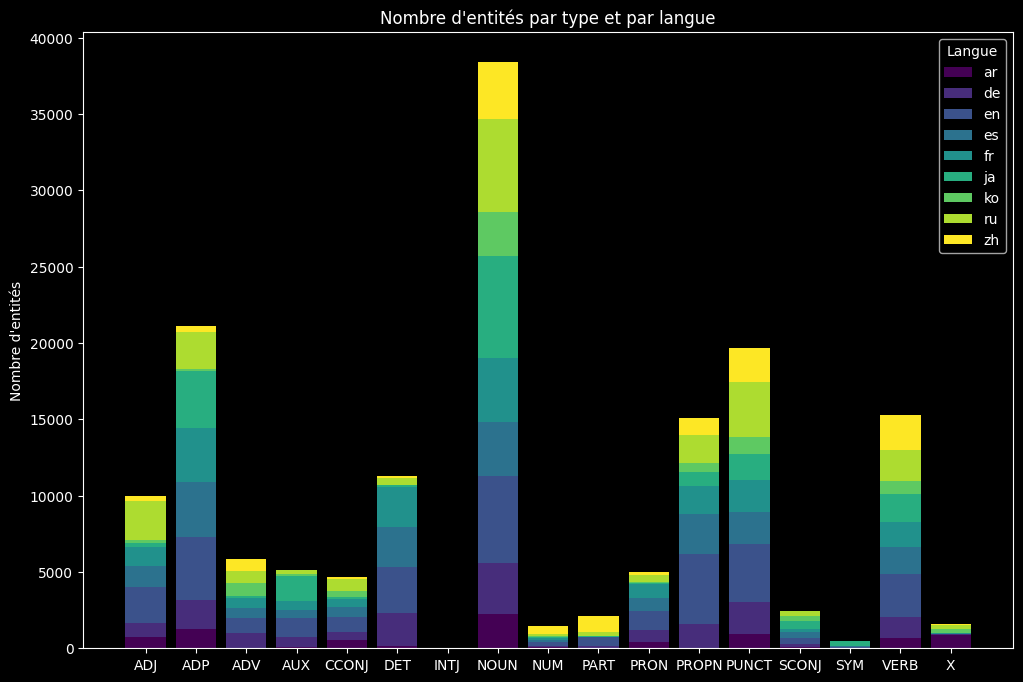

In [7]:
def plot_entity_distribution(data: dict) -> plt.Figure:
    """
    Trace un graphique en barres empilées des entités par langue pour chaque type d'entité.

    Parameters:
    data (dict): Dictionnaire des entités triées retourné par la fonction count_entities.

    Returns:
    plt.Figure: le graphique tracé.
    """
    # Préparation des données pour le tracé
    languages = set()
    for entities in data.values():
        languages.update(entities.keys())
    languages = sorted(languages)

    # Création de données pour le tracé
    labels = list(data.keys())
    bottom = [0] * len(labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(languages)))
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for idx, lang in enumerate(languages):
        counts = [data[pos].get(lang, 0) for pos in labels]
        ax.bar(labels, counts, bottom=bottom, color=colors[idx], label=lang)
        bottom = [i + j for i, j in zip(bottom, counts)]
    
    ax.set_ylabel('Nombre d\'entités')
    ax.set_title('Nombre d\'entités par type et par langue')
    ax.legend(title='Langue')

    return fig

distribution = plot_entity_distribution(entities)

# save the plot
distribution.savefig('../../resultats/entity_distribution.png')

1. **Répartition par Langue** :
   - **Anglais, français et russe** : Bien que le français, l'anglais et le russe soient présents dans presque toutes les catégories d'entités, l'anglais semble avoir une représentation légèrement plus équilibrée à travers différentes catégories comparé aux autres langues.
   - **Japonais et chinois** : En effet, le japonais et le chinois montrent des concentrations élevées dans certaines catégories telles que les adpositions (ADP) pour le japonais et les noms (NOUN) pour le chinois.

2. **Types d'Entités** :
   - **Noms (NOUN)** : Il est à noter que le japonais, avec 6690 occurrences, domine cette catégorie, suivis par le français. Ceci suggère que la structure des données en japonais est fortement orientée vers l'usage des noms.
   - **Adpositions (ADP)** : Le japonais montre également une forte présence ici, ce qui est cohérent avec la nature syntaxique du japonais où les particules jouent un rôle crucial dans l'indication de la fonction grammaticale des mots dans les phrases.
   - **Ponctuation (PUNCT)** : Le russe domine cette catégorie, mais l'anglais n'est pas loin derrière. 

3. **Représentation des Langues Moins Courantes** :
   - Les faibles chiffres pour les langues comme le coréen et l'arabe dans plusieurs catégories suggèrent en effet une sous-représentation. Cela peut affecter la performance des modèles de traitement automatique de la langue pour ces langues.


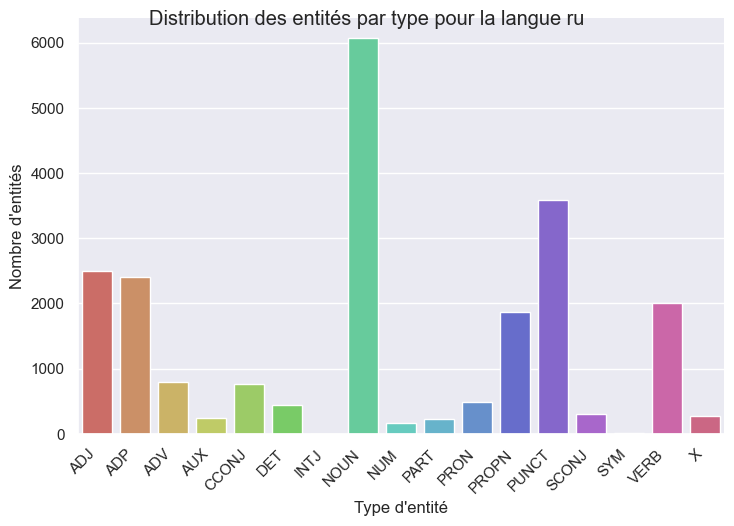

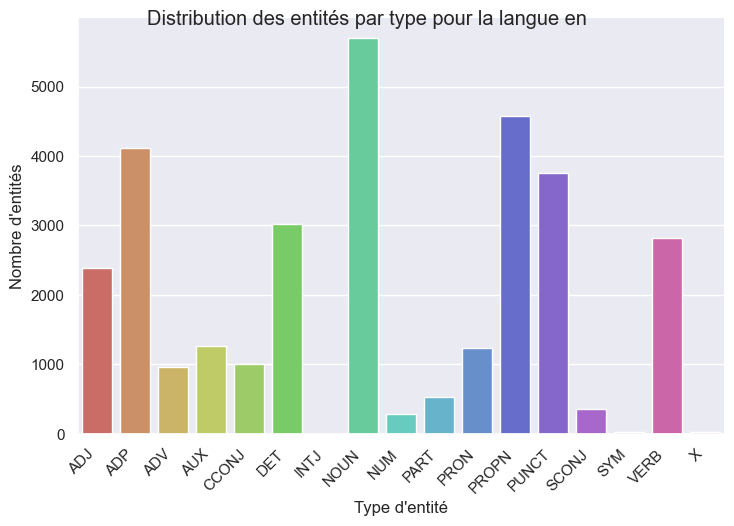

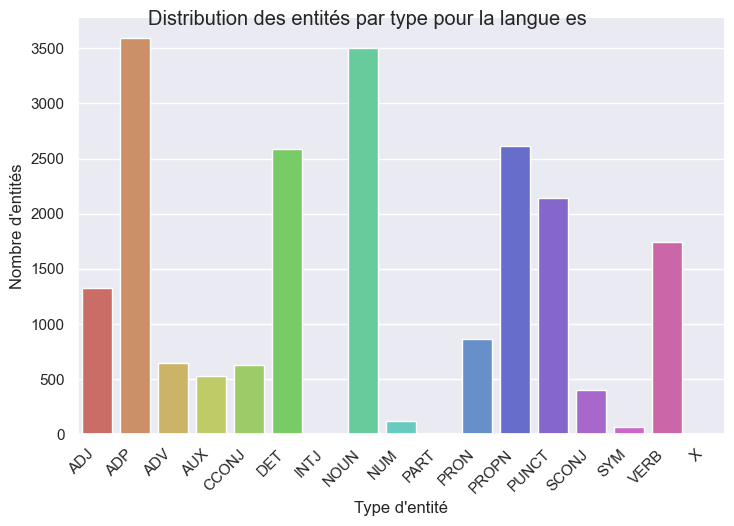

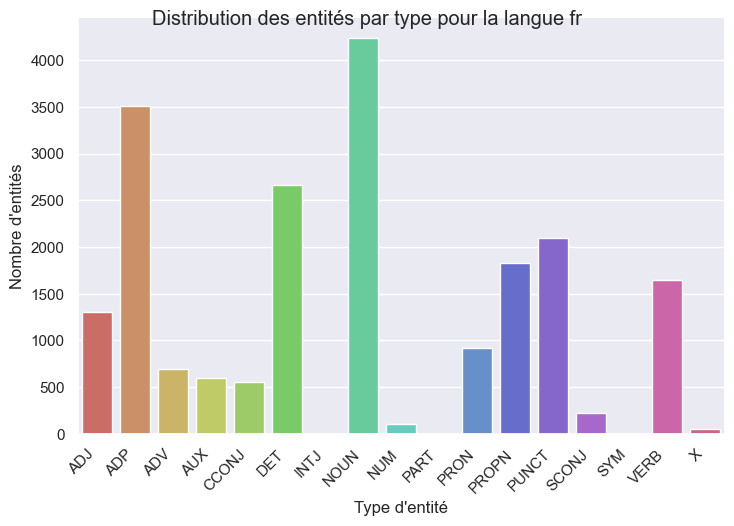

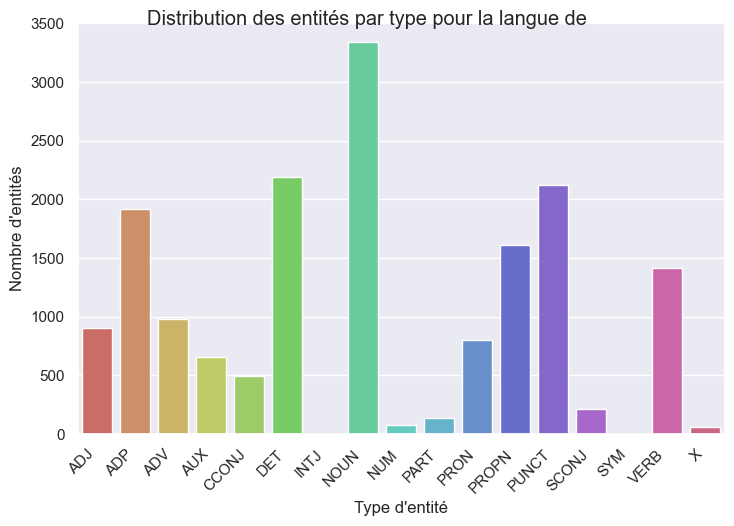

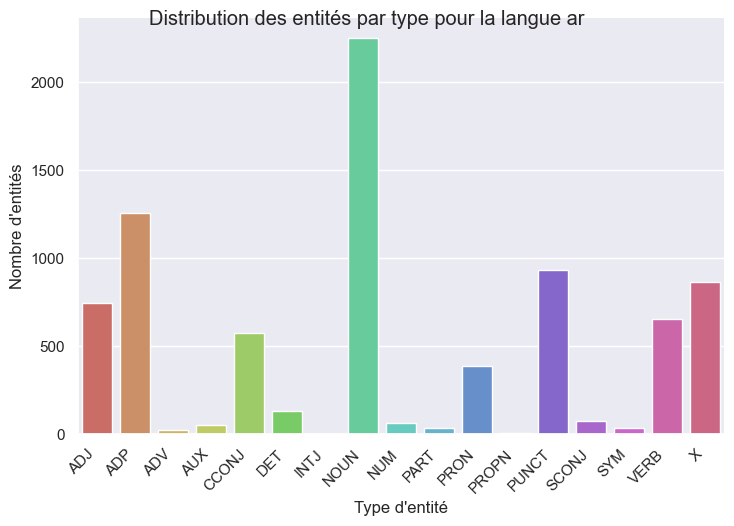

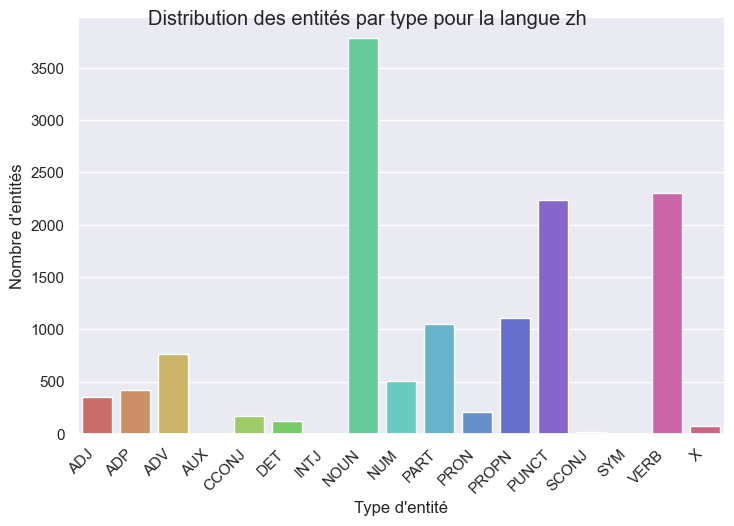

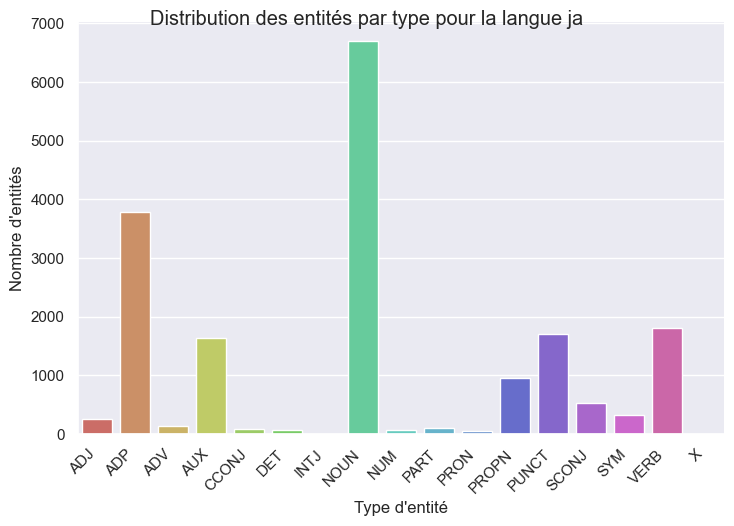

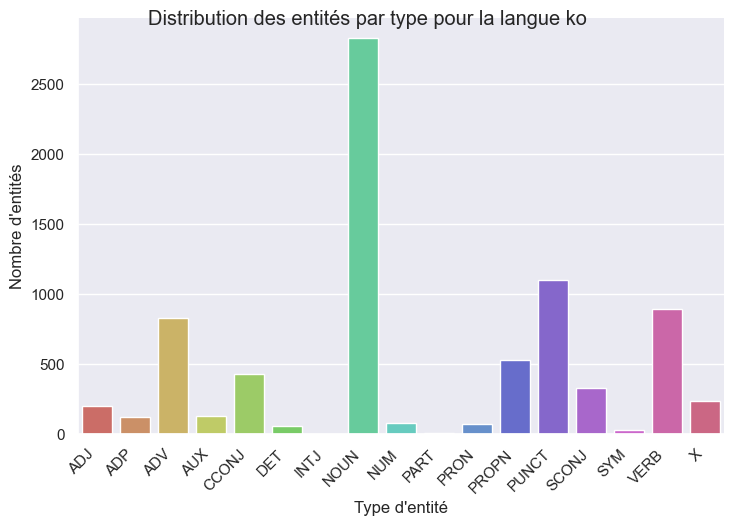

In [8]:
def plot_entity_distribution_per_language(data: pd.DataFrame, output_directory: str):
    """
    Trace un graphique en barres pour chaque langue montrant la distribution des entités par type.

    Parameters:
    data (pd.DataFrame): DataFrame des entités retourné par la fonction count_entities.
    output_directory (str): Répertoire dans lequel enregistrer les graphiques.
    """
    # Tracé des graphiques séparés pour chaque langue
    for lang in data['Unnamed: 0'].unique():
        # Filtrer les données pour la langue spécifique
        data_lang = data[data['Unnamed: 0'] == lang]

        # Convertir le DataFrame en format long
        data_lang_long = data_lang.melt(id_vars=['Unnamed: 0'], var_name='Type d\'entité', value_name='Count')

        # Renommer les colonnes pour correspondre à ce que la fonction plot_entity_distribution_per_language attend
        data_lang_long.rename(columns={'Unnamed: 0': 'Language'}, inplace=True)

        # Création d'une palette de couleurs personnalisée basée sur le nombre de types d'entités
        num_entity_types = len(data_lang_long['Type d\'entité'].unique())
        custom_palette = sns.color_palette("hls", num_entity_types)

        # Tracé avec Seaborn en utilisant la palette personnalisée
        sns.set(style="darkgrid")
        g = sns.catplot(x="Type d\'entité", y="Count", hue='Type d\'entité', data=data_lang_long, kind="bar", height=5, aspect=1.5, palette=custom_palette, legend=False)
        g.set_xticklabels(rotation=45, ha='right')
        g.set_axis_labels('Type d\'entité', 'Nombre d\'entités')
        g.fig.suptitle(f'Distribution des entités par type pour la langue {lang}')

        # Enregistrement du graphique
        g.savefig(f"{output_directory}/{lang}_distribution.png", facecolor='w')
        plt.show()
        plt.close()

# Utilisation de la fonction
data = pd.read_csv("../../resultats/entities.csv")
plot_entity_distribution_per_language(data, '../../resultats/POS_distribution_per_lang')

1. **Boucle à travers les langues** :
   - La fonction utilise une boucle `for` pour traiter chaque langue dans les données. Elle utilise la colonne `Unnamed: 0` pour identifier les différentes langues.

2. **Préparation des données** :
   - Pour chaque langue, les données sont filtrées pour ne garder que celles correspondant à la langue en question.
   - Les données sont converties en un format long, où chaque ligne représente une observation unique du type d'entité et du nombre d'entités.

3. **Renommer les colonnes** :
   - La colonne `Unnamed: 0` est renommée en `Language` pour rendre le code plus lisible.

4. **Tracer le graphique** :
   - Avec Seaborn, le graphique est créé en utilisant les types d'entités comme étiquettes sur l'axe des x, et le nombre d'entités sur l'axe des y. La couleur des barres varie selon le type d'entité. 
   - Les étiquettes des axes sont ajustées pour être claires et lisibles, et un titre est ajouté.

5. **Enregistrer le graphique** :
   - Le graphique est sauvegardé dans le répertoire spécifié, avec un fond blanc.

6. **Utilisation de la fonction** :
   - Les données sont lues à partir d'un fichier CSV et la fonction est appelée avec ces données et le répertoire de sortie.